In [2]:
pip install snowflake-connector-python pandas scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [4]:
!pip install xgboost

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/150.0 MB ? eta -:--:--
   ---------------------------------------- 1.0/150.0 MB 4.2 MB/s eta 0:00:36
    --------------------------------------- 2.1/150.0 MB 5.6 MB/s eta 0:00:27
   - -------------------------------------- 4.2/150.0 MB 6.0 MB/s eta 0:00:25
   - -------------------------------------- 4.2/150.0 MB 6.0 MB/s eta 0:00:25
   - -------------------------------------- 4.2/150.0 MB 6.0 MB/s eta 0:00:25
   - -------------------------------------- 5.0/150.0 MB 4.0 MB/s eta 0:00:37
   - -------------------------------------- 5.8/150.0 MB 3.7 MB/s eta 0:00:39
   - -------------------------------------- 6.8/150.0 MB 3.9 MB/s eta 0:00:37
   -- ------------------------------------- 8.4/150.0 MB 4.2 MB/s eta 0:00:34
   -- ------------------------------------- 9.2/150.0 MB 4.2 MB/s eta 0:00:34
   -- ------------------------------------- 9.4/150.0 MB 4.2 MB/s eta 0:00:34


In [253]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import snowflake.connector
from sklearn.ensemble import RandomForestClassifier

In [254]:
conn = snowflake.connector.connect(
    user='bigdatadeiyo',
    password='Ramikasatha1130',
    account='FNMMMLV-XE53969',
    warehouse='COMPUTE_WH',
    database='TEST1',
    schema='STREAM'
    )

In [255]:
cursor = conn.cursor()
cursor.execute("SELECT * FROM TEST1_FEATUREENG")
columns = [col[0] for col in cursor.description]
data = cursor.fetchall()
cursor.close()
conn.close()

In [256]:
df = pd.DataFrame(data, columns=columns)

In [257]:
categorical_cols = ['GENDER_LABEL', 'EDUCATION_LABEL', 'ETHNICITY_LABEL', 'BMI_CATEGORY', 'AGE_GROUP']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [258]:
X = df.drop(columns=['DIAGNOSIS'])

# Drop unnecessary object columns like PARKINSON_DIAGNOSIS (non-numeric)
if 'PARKINSON_DIAGNOSIS' in X.columns:
    X = X.drop(columns=['PARKINSON_DIAGNOSIS'])

# Ensure all columns are numeric
for col in X.columns:
    if X[col].dtype == 'object':
        try:
            X[col] = X[col].astype(float)
        except ValueError:
            print(f"Could not convert column '{col}' to float. Check its contents.")

# Final check and conversion
X = X.select_dtypes(include=[np.number])
y = df['DIAGNOSIS']

In [259]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## XGBOOST

In [260]:
param_dist = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3]
}

In [261]:
xgb_clf = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    verbosity=0
)

grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    verbose=1
)

random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=200,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

In [180]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 729 candidates, totalling 2187 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 4, 5], 'min_child_weight': [1, 3, 5],
                         'n_estimators': [100, 150, 200],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring='accuracy', verbose=1)

In [181]:
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_cons...
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None, ...),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 0.1, 0.2, 0.3],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 4, 5, 6],
                                        'min_child_weight': [1, 3, 5, 7],
                                        'n_estimators': [100, 150, 200, 250],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='accuracy', verbose=1)

In [182]:
best_model_grid = grid_search.best_estimator_
y_pred_grid = best_model_grid.predict(X_test)

print("GridSearchCV Accuracy:", accuracy_score(y_test, y_pred_grid))
print("GridSearchCV Report:\n", classification_report(y_test, y_pred_grid))


# RandomizedSearchCV Results
best_model_random = random_search.best_estimator_
y_pred_random = best_model_random.predict(X_test)

print("RandomizedSearchCV Accuracy:", accuracy_score(y_test, y_pred_random))
print("RandomizedSearchCV Report:\n", classification_report(y_test, y_pred_random))

GridSearchCV Accuracy: 0.8582834331337326
GridSearchCV Report:
               precision    recall  f1-score   support

           0       0.83      0.81      0.82       200
           1       0.88      0.89      0.88       301

    accuracy                           0.86       501
   macro avg       0.85      0.85      0.85       501
weighted avg       0.86      0.86      0.86       501

RandomizedSearchCV Accuracy: 0.8542914171656687
RandomizedSearchCV Report:
               precision    recall  f1-score   support

           0       0.82      0.82      0.82       200
           1       0.88      0.88      0.88       301

    accuracy                           0.85       501
   macro avg       0.85      0.85      0.85       501
weighted avg       0.85      0.85      0.85       501



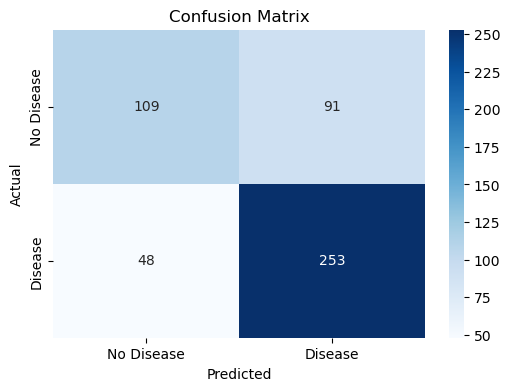

In [183]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Disease", "Disease"],
            yticklabels=["No Disease", "Disease"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

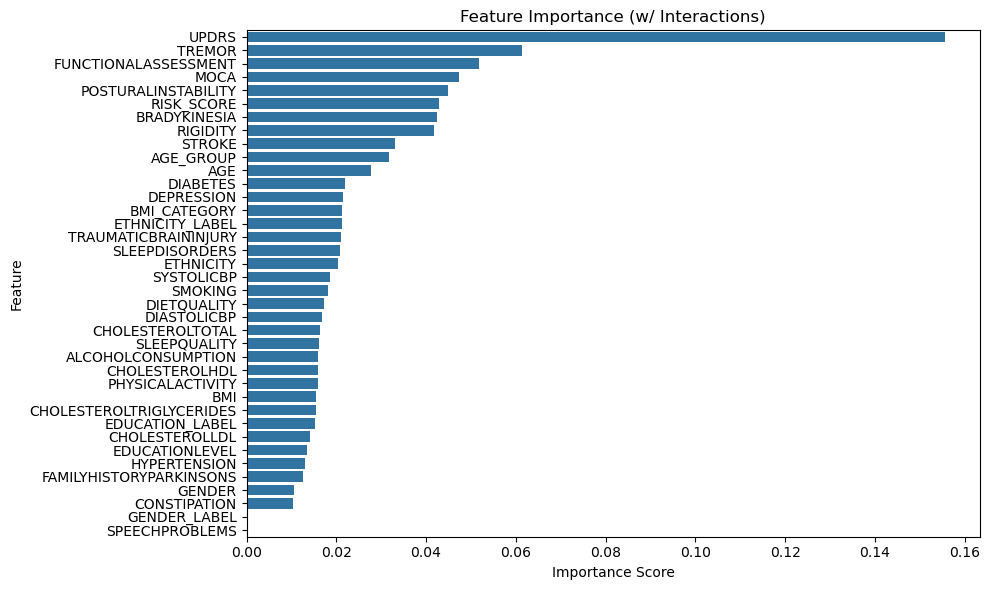

In [184]:
importance = model.feature_importances_
sorted_idx = np.argsort(importance)[::-1]
features_sorted = X.columns[sorted_idx]
importance_sorted = importance[sorted_idx]

plt.figure(figsize=(10, 6))
sns.barplot(x=importance_sorted, y=features_sorted)
plt.title("Feature Importance (w/ Interactions)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

## Random Forest

In [262]:
param_dist_rf = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

In [263]:
rf = RandomForestClassifier(random_state=42)

In [264]:
random_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist_rf,
    n_iter=100,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

In [243]:
random_search_rf.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 5, 10, 15],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 3],
                                        'min_samples_split': [2, 4, 6],
                                        'n_estimators': [100, 150, 200, 250]},
                   random_state=42, scoring='accuracy', verbose=1)

In [244]:
best_rf = random_search_rf.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)

print("Tuned RF Accuracy:", accuracy_score(y_test, y_pred_best_rf))
print("Best Parameters:", random_search_rf.best_params_)
print("Classification Report:\n", classification_report(y_test, y_pred_best_rf))

Tuned RF Accuracy: 0.8602794411177644
Best Parameters: {'n_estimators': 250, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 15, 'bootstrap': False}
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.79      0.82       200
           1       0.87      0.91      0.89       301

    accuracy                           0.86       501
   macro avg       0.86      0.85      0.85       501
weighted avg       0.86      0.86      0.86       501



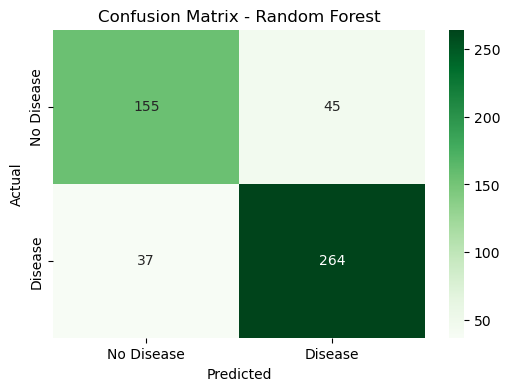

In [245]:
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens",
            xticklabels=["No Disease", "Disease"],
            yticklabels=["No Disease", "Disease"])
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

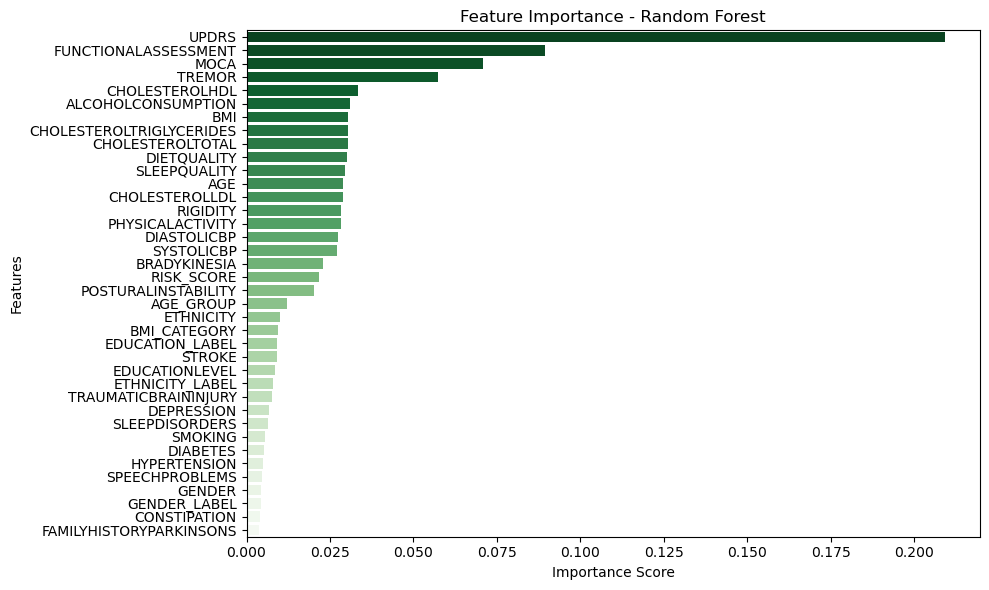

In [249]:
plt.figure(figsize=(10, 6))
sns.barplot(
    x=importances_sorted,
    y=features_sorted,
    hue=features_sorted,             
    palette="Greens_r",
    dodge=False,                     
    legend=False                     
)
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()